In [93]:
#EXPLORATORY ANALYSIS

#Import the necessary packages required to process the data, build, and evaluate the model.

import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [94]:

KNOWN_IMAGES = "D:/deep_learning_project/dataset1/known_images/"

In [96]:
#Read all file paths for the images in the dataset1 directory
primitive_hash = list() 

for file_path in glob.glob(KNOWN_IMAGES+"*.png"):
    file_name = os.path.basename(file_path)
    category = file_name.split("_")[0]
    primitive_hash.append({"category":category,"im_path":file_name})

df = pd.DataFrame(primitive_hash)

In [97]:
df.head(12)

,category,im_path
0,normal,normal_0.png
1,normal,normal_1.png
2,normal,normal_10.png
3,normal,normal_101.png
4,normal,normal_102.png
5,normal,normal_103.png
6,normal,normal_104.png
7,normal,normal_105.png
8,normal,normal_106.png
9,normal,normal_107.png


<AxesSubplot: >

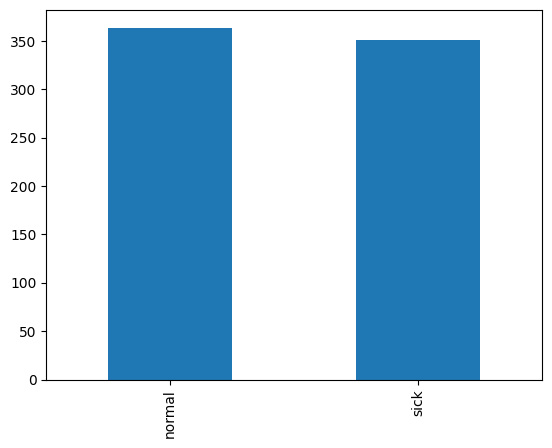

In [98]:
#Investigate class distribution, to see if there is no sample bias

df['category'].value_counts().plot(kind="bar")

In [99]:
class_names = list()
images = list()
for k in df.sample(6).itertuples():
    class_names.append(k[1])
    img = cv2.imread(KNOWN_IMAGES+k[2])
    images.append(img)

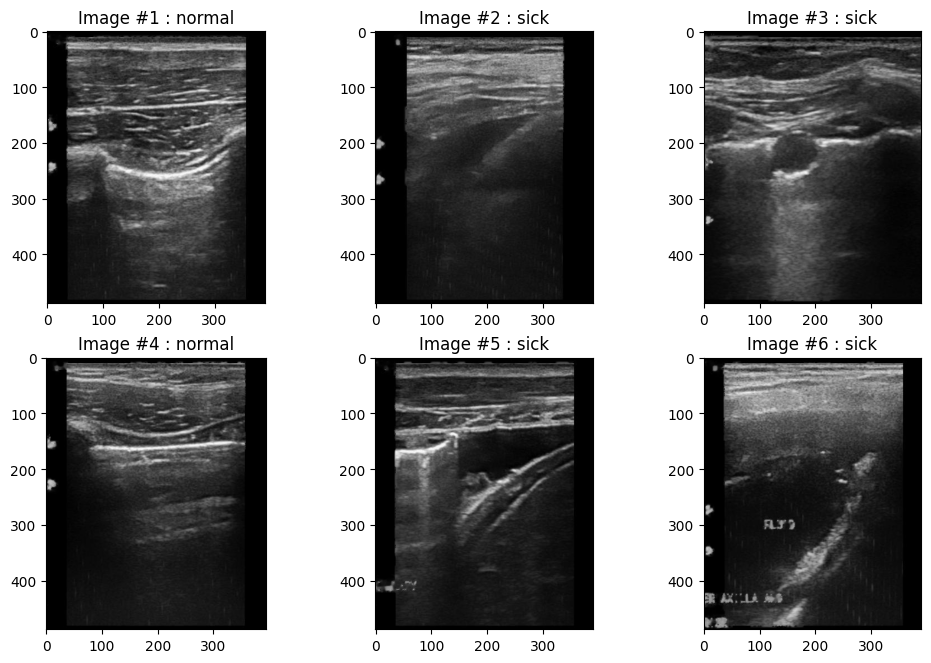

In [100]:
#Read & View a few images from the dataset

plt.figure(figsize=(12,12))
columns = 3
for i in range(6):
    plt.subplot(int(len(images)/ columns + 1), columns, i + 1)
    plt.imshow(images[i])
    plt.title('Image #{} : '.format(i+1) + class_names[i])

In [102]:
#Save dataset paths and categories
df.to_json("D:/deep_learning_project/processed_json_file/data_for_known_images.json")


In [103]:
#PREPARE DATASET AND TRAIN

import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.regularizers import l1,l2

import cv2
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from time import time
import numpy as np


In [104]:
df = pd.read_json("D:/deep_learning_project/processed_json_file/data_for_known_images.json")

In [105]:
df.head()

,category,im_path
0,normal,normal_0.png
1,normal,normal_1.png
2,normal,normal_10.png
3,normal,normal_101.png
4,normal,normal_102.png


In [106]:
KNOWN_IMAGES = "D:/deep_learning_project/dataset1/known_images/"

In [107]:
import pickle

lbr = preprocessing.LabelBinarizer().fit(df.category)

with open('binarizer', 'wb') as handle:
    pickle.dump(lbr,handle)

In [108]:
df['label'] = lbr.transform(df.category)

new_df = df.copy()

new_df.drop("category",axis=1,inplace=True)

In [109]:
new_df

,im_path,label
0,normal_0.png,0
1,normal_1.png,0
2,normal_10.png,0
3,normal_101.png,0
4,normal_102.png,0
...,...,...
710,sick_94.png,1
711,sick_96.png,1
712,sick_97.png,1
713,sick_98.png,1


In [110]:
train, valid = train_test_split(new_df, test_size=0.2, random_state=1)

In [111]:
train

,im_path,label
622,sick_349.png,1
600,sick_328.png,1
709,sick_93.png,1
664,sick_5.png,1
449,sick_180.png,1
...,...,...
144,normal_233.png,0
645,sick_37.png,1
72,normal_165.png,0
235,normal_318.png,0


In [112]:
train_data = {"features":[],"labels":[]}
test_data = {"features":[],"lables":[]}

In [113]:
def read_img(file_path:str):
    img_gray = cv2.imread(KNOWN_IMAGES+file_path,cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_AREA)
    im_bw = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)[1]
    return im_bw

In [114]:

import matplotlib.pyplot as plt

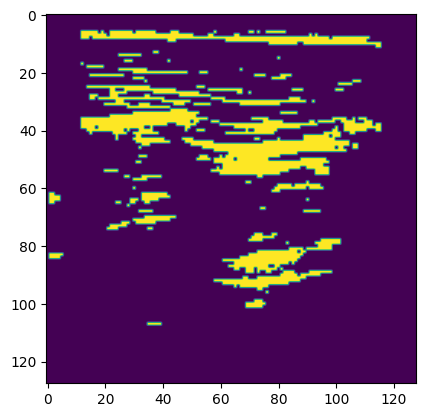

In [117]:

plt.imshow(read_img("normal_166.png"))

In [118]:
train_data['labels'] = train['label']

In [119]:
train_data['features'] = train.im_path.apply(lambda x: read_img(x))

In [120]:

test_data['lables'] = valid['label']

In [121]:
test_data['features'] = valid.im_path.apply(lambda x: read_img(x))

In [122]:
X_features = []

for i in train_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    X_features.append(k)

X_features = np.stack(X_features, axis=0)

In [123]:

X_features.shape

(572, 128, 128, 1)

In [124]:
X_labels = []

for i in train_data['labels']:
    X_labels.append(i)
    
X_labels = np.reshape(X_labels, (len(X_labels),-1))

In [125]:
Y_features = []

for i in test_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    Y_features.append(k)
    
Y_features = np.stack(Y_features,axis=0)

In [126]:
Y_labels = []

for i in test_data['lables']:
    Y_labels.append(i)
    

Y_labels = np.reshape(Y_labels, (len(Y_labels),-1))

In [127]:
model = Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(128,128,1),
                        kernel_regularizer=l2(0.0001)))
model.add(layers.AveragePooling2D())
model.add(layers.Dropout(0.52))

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',kernel_regularizer=l1(0.1)))
model.add(layers.AveragePooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu',kernel_regularizer=l1(0.1)))
model.add(layers.Dropout(0.12))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=1, activation = 'sigmoid'))

In [128]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 6)       60        
                                                                 
 average_pooling2d_2 (Averag  (None, 63, 63, 6)        0         
 ePooling2D)                                                     
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 6)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 30, 30, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 16)       

In [135]:
bce = keras.losses.BinaryCrossentropy(from_logits=False)

#model.compile(loss=bce, optimizer=keras.optimizers.adam_v2.Adam(), metrics=['accuracy'])
model.compile(loss=bce, optimizer="Adam", metrics=['accuracy'])

EPOCHS = 18
BATCH_SIZE = 30


train_generator = ImageDataGenerator(shear_range=0.72,
        zoom_range=0.72,horizontal_flip=True).flow(X_features, X_labels, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(Y_features, Y_labels, batch_size=BATCH_SIZE)



In [136]:
steps_per_epoch = X_features.shape[0]//BATCH_SIZE
validation_steps = Y_features.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

#model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

Epoch 1/18
19/19 [==============================] - 8s 268ms/step - loss: 811.4916 - accuracy: 0.6476 - val_loss: 213.8407 - val_accuracy: 0.6250
Epoch 2/18
19/19 [==============================] - 4s 226ms/step - loss: 146.1833 - accuracy: 0.7399 - val_loss: 80.8346 - val_accuracy: 0.6083
Epoch 3/18
19/19 [==============================] - 4s 194ms/step - loss: 53.8125 - accuracy: 0.7011 - val_loss: 36.7022 - val_accuracy: 0.7917
Epoch 4/18
19/19 [==============================] - 4s 230ms/step - loss: 31.8595 - accuracy: 0.7122 - val_loss: 28.2935 - val_accuracy: 0.7500
Epoch 5/18
19/19 [==============================] - 5s 241ms/step - loss: 30.1595 - accuracy: 0.6716 - val_loss: 28.6189 - val_accuracy: 0.7000
Epoch 6/18
19/19 [==============================] - 4s 216ms/step - loss: 26.5828 - accuracy: 0.6974 - val_loss: 25.8145 - val_accuracy: 0.6417
Epoch 7/18
19/19 [==============================] - 4s 228ms/step - loss: 24.3112 - accuracy: 0.7649 - val_loss: 23.5212 - val_accura

In [179]:
model.save("D:/deep_learning_project/mycode")

INFO:tensorflow:Assets written to: D:/deep_learning_project/mycode\assets


INFO:tensorflow:Assets written to: D:/deep_learning_project/mycode\assets


In [180]:
from sklearn.metrics import precision_score, recall_score

y_pred = model.predict(Y_features)

7/7 [==============================] - 0s 35ms/step


In [181]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

In [184]:
precision_score(Y_labels,y_pred)

0.5339805825242718

In [186]:
recall_score(Y_labels,y_pred)

0.49107142857142855

In [187]:
#PREDICT ON UNKNOWN 

import keras
import pickle
import cv2
import glob
import os
import numpy as np

In [188]:
UNKNOWN_IMAGES = "D:/deep_learning_project/dataset1/unknown_images/"

In [189]:
import pandas as pd

primitive_hash = list()

for file_path in glob.glob(UNKNOWN_IMAGES+"*.png"):
    file_name = os.path.basename(file_path)
    primitive_hash.append({"im_path":file_name})
    
df = pd.DataFrame(primitive_hash)

In [190]:
df.head()

,im_path
0,1.png
1,10.png
2,11.png
3,12.png
4,13.png


In [191]:
test_data = {"features":[],"lables":[]}

def read_img(file_path:str):
    img_gray = cv2.imread(UNKNOWN_IMAGES+file_path,cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_AREA)
    im_bw = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)[1]
    return im_bw


In [192]:

test_data["features"] = df.im_path.apply(lambda x: read_img(x))

In [194]:
Y_features = []

for i in test_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    Y_features.append(k)
    


In [195]:
Y_features = np.stack(Y_features, axis=0)

In [196]:
Y_features.shape

(50, 128, 128, 1)

In [197]:
model = keras.models.load_model("D:/deep_learning_project/mycode")

In [198]:
y_pred = model.predict(Y_features)

2/2 [==============================] - 0s 89ms/step


In [199]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

with open('binarizer', 'rb') as handle:
    lbr = pickle.load(handle)
    
df['category'] = lbr.inverse_transform(np.array(y_pred))

In [200]:
df

,im_path,category
0,1.png,normal
1,10.png,sick
2,11.png,normal
3,12.png,normal
4,13.png,normal
5,14.png,normal
6,15.png,normal
7,16.png,sick
8,17.png,normal
9,18.png,normal


In [201]:
df.to_json("D:/deep_learning_project/processed_json_file/unknown_data.json")

In [202]:
df.to_csv("D:/deep_learning_project/unknown_data_predictions.csv")

In [203]:
#PREDICT ON DATASET 2 

import pandas as pd
import cv2
import numpy as np
from sklearn.metrics import precision_score,recall_score,accuracy_score
from keras.models import load_model

In [204]:
IMG_PATH = "D:/deep_learning_project/dataset2/images/"

In [205]:
df = pd.read_csv("D:/deep_learning_project/dataset2/image_classes.csv")

In [206]:
df.head()

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0,0
1,sick_eff1,0
2,sick_eff2,0
3,sick_eff3,0
4,sick_eff4,0


In [207]:
def read_img(file_path:str):
    img_gray = cv2.imread(IMG_PATH+file_path+".png",cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_AREA)
    im_bw = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)[1]
    return im_bw

In [208]:
df['labels'] = df['diagnosis (0-Normal, 1-Sick)']

In [ ]:
test_data = {"features":[],"labels":[]}

In [209]:
test_data["features"] = df['patient '].apply(read_img)

test_data["labels"] = df["labels"]

In [210]:
Y_features = []

for i in test_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    Y_features.append(k)
    

Y_features = np.stack(Y_features,axis=0)

In [211]:
Y_labels = []

for i in test_data['labels']:
    Y_labels.append(i)
    
Y_labels = np.reshape(Y_labels, (len(Y_labels),-1))

In [212]:
model = load_model("D:/deep_learning_project/mycode")

In [213]:
y_pred = model.predict(Y_features)

7/7 [==============================] - 1s 140ms/step


In [214]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

In [215]:
precision_score(Y_labels,y_pred)

0.5339805825242718

In [216]:
recall_score(Y_labels,y_pred)

0.49107142857142855

In [217]:
accuracy_score(Y_labels,y_pred)

0.53125